# Implementation of Sparse Singular Value Decomposition


### Yutong Zhang, Jiaxi Yin

Github link: https://github.com/Yutong-Z/Sparse-SVD-Algorithm

Package should be installed by `pip install SSVD663`

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import SparsePCA
import multiprocessing as mp
from multiprocessing import Pool
from functools import partial
import time

%matplotlib inline

## 1. Abstract

The sparse singular value decomposition algorithm is to find the best checkerboard structured matrix approximation to the data matrix, which is used as biclustering. We implemented the algorithm based on the iterative method introduced in "Biclustering via Sparse Singular Value Decomposition" and tried to optimize it using jit and parallelism. We then applied this algorithm to two real world datasets and a simulated dataset to test it. Finally we compared SSVD to SPCA and LASSO regression and evaluated their performance.

## 2. Background

This paper is based on "Biclustering via Sparse Singular Value Decomposition" written by Mihee Lee, Haipeng Shen, Jianhua Z. Huang, and J. S. Marron. In recent years, with the development of gene chips and DNA microarrays, numerous gene expression data have been generated. Effective analysis of these data has become the focus of research. Traditional clustering can only find global information, but cannot find local information, and a large amount of biological information is hidden in these local information. In order to better search for local information in the data matrix, the concept of biclustering has been proposed.

Biclustering is an unsupervised learning technique allowing simultaneous clustering of the rows and columns of a matrix. It has been more and more widely used at present. Sparse singular value decomposition is a biclustering algorithm exploring high-dimensional low sample size datasets. It is useful in text categorization, medical imaging, and microarray gene expression analysis. For microarray gene expression analysis,  it is possible to identify groups of genes related to different diseases.

The only difference between SSVD and SVD is that SSVD imposes sparsity on singular vectors. This is the biggest advantage of SSVD. The sparse singular vectors are easy to be explained intuitively and the inherent patterns from the data matrix are easy to be captured.

## 3. Description of algorithm


Sparse singular value decomposition is a algorithm used to find low-rank checkerboard structured matrix approximation to data matrices. This can be transformed to two linear regressions. For a fixed $u$, $min ∥X−u\tilde{v}^T ∥^2_F + \lambda_v P_2(\tilde{v})$ where $\tilde{v} = sv$, $Y = (x^T_1 ,...,x^T_d )^T \in R^{n\times d}$ with $x_j$ being the jth column of X. For a fixed $v$, $min ∥Z−\tilde{u}v^T ∥^2_F + \lambda_u P_1(\tilde{u})$ where $\tilde{u} = su$, $Z = (x_1 ,...,x_d )^T \in R^{n\times d}$ with $x^T_i$ being the ith row of X. The regression coefficients are the corresponding entries of singular vecters. $P_2(sv) = s \sum_{j=1}^n w_{2,j} |v_j|$, $P_1(su) = s \sum_{i=1}^n w_{1,i} |u_i|$. By imposing L1 regularization penalties with different weights, the left singular vecter and right singular vecter can be sparse, which ensures checkerboard structure of the approximated matrix.

For penalty parameter selection, the paper introduces $BIC(\lambda) = \frac{\left\lVert X-\hat{X}\right\rVert^2}{nd\cdot \hat{\sigma^2}} + \frac{log(nd)}{nd}\hat{df}(\lambda)$. We should choose the penalty parameter with the smallest BIC value.

Below is pseudocode to find sigular value, left singular vector and right singular vector of the first SSVD layer. Then the first layer is $suv^T$. The next SSVD layer can be obtained by applying the same algorithm to $X - suv^T$.

$Step$ 1:

Apply the standard SVD to the dataset matrix $X$. Let {$s_{old}$, $u_{old}$, $v_{old}$} denote the first SVD triplet.

$Step$ 2: 

Update

(a) Set $\tilde{v_j} = sign{(X^T u_{old})_j}(\mid(X^T u_{old})_j\mid-\lambda_v w_{2, j} \;/\; 2)_{+}$, $j = 1, \cdots, d$, where $\lambda_v$ is the minimizer of $BIC(\lambda_v) = \frac{\left\lVert Y-\hat{Y}\right\rVert^2}{nd\cdot \hat{\sigma^2}} + \frac{log(nd)}{nd}\hat{df}(\lambda_v)$

Let $\tilde{v} = (\tilde{v_1}, \cdots, \tilde{v_d})^T$, $s = \left\lVert \tilde{v}\right\rVert$, and $v_{new} = \tilde{v}/s$

(b) Set $\tilde{u_i} = sign{(X^T v_{old})_i}(\mid(X^T v_{old})_i\mid-\lambda_u w_{1, i} \;/\; 2)_{+}$, $i = 1, \cdots, d$, where $\lambda_u$ is the minimizer of $BIC(\lambda_u) = \frac{\left\lVert Z-\hat{Z}\right\rVert^2}{nd\cdot \hat{\sigma^2}} + \frac{log(nd)}{nd}\hat{df}(\lambda_u)$

Let $\tilde{u} = (\tilde{u_1}, \cdots, \tilde{u_d})^T$, $s = \left\lVert \tilde{u}\right\rVert$, and $u_{new} = \tilde{u}/s$

(c) Set $u_{old} = u_{new}$ and repeat Steps 2(a) and 2(b) until convergence.

$Step$ 3:

Set $u = u_{new}$, $v = v_{new}$, $s = u_{new}^TXv_{new}$ at convergence.

## 3. Describe optimization for performance

### python implementation

In [2]:
def update_u(X,u,v,s,n,d,gamma_u):
    '''
    update the left singular vector
    
    X = data matrix
    u = left singular vector from last iteration
    v = right singular vector from last iteration
    s = sigular value
    n = the number of rows in the data matrix X
    d = the number of columns in the data matrix X
    gamma_u = weight parameter
    '''
    Xv = X @ v
    w1 = np.abs(Xv) ** (-gamma_u)
    lambdas = np.sort(np.unique(np.append(np.abs(Xv / w1), 0)))[0:-1]
    BICs = []
    us = []
    sigmaS = np.sum((X - s * u @ v.T) ** 2) / (n*d - d)  
    for lambda_u in lambdas:
        u_h = np.sign(Xv) * (np.abs(Xv) >= (lambda_u * w1)) * (np.abs(Xv) - lambda_u * w1)
        BIC = np.sum((X - u_h @ v.T) ** 2) / sigmaS / n / d + np.sum(u_h != 0) * np.log( n*d ) / n / d
        BICs.append(BIC)
        us.append(u_h)
    u_new = us[BICs.index(min(BICs))]
    
    u_new = u_new / np.sqrt(np.sum(u_new ** 2))
    return u_new

def update_v(X,u,v,s,n,d,gamma_v):
    '''
    update the right singular vector
    
    X = data matrix
    u = left singular vector from last iteration
    v = right singular vector from last iteration
    s = sigular value
    n = the number of rows in the data matrix X
    d = the number of columns in the data matrix X
    gamma_v = weight parameter
    '''
    Xu = X.T @ u
    w2 = np.abs(Xu) ** (-gamma_v)
    lambdas = np.sort(np.unique(np.append(np.abs(Xu / w2), 0)))[0:-1]
    BICs = []
    vs = []
    sigmaS = np.sum((X - s * u @ v.T) ** 2) / (n*d - d)  
    for lambda_v in lambdas:
        v_h = np.sign(Xu) * (np.abs(Xu) >= (lambda_v * w2)) * (np.abs(Xu)-lambda_v * w2)
        BIC = np.sum((X-u @ v_h.T) ** 2) / sigmaS / n / d + np.sum(v_h != 0) * np.log(n * d) / n / d
        BICs.append(BIC)
        vs.append(v_h)
    v_new = vs[BICs.index(min(BICs))]
    
    v_new = v_new / np.sqrt(np.sum(v_new ** 2))
    return v_new

def SSVD(X, gamma_u = 2, gamma_v=2, tol = 1e-4):
    
    '''
    SSVD for the first layer
    
    X = data matrix
    gamma_u, gamma_v = weight parameters, default = 2
    tol = tolerance for convergence, default to 1e-4
    '''
    

    
    U, S, Vt = np.linalg.svd(X)
    u = U[:,0].reshape(-1,1)
    v = Vt[0].reshape(-1,1)
    s = S[0]
    n = X.shape[0]
    d = X.shape[1]
    
    du = 1
    dv = 1
  

    while((du > tol) or (dv > tol)):
        v_new = update_v(X,u,v,s,n,d,gamma_v)
        dv = np.sqrt(np.sum((v - v_new) ** 2))
        v = v_new

        u_new = update_u(X,u,v,s,n,d,gamma_u)
        du = np.sqrt(np.sum((u - u_new) ** 2))
        u = u_new

    s = u.T @ X @ v

    return u, s, v

In [3]:
df = pd.read_csv('LungCancerData.txt', sep=' ', header = None).T
cancer = np.array(df)

In [24]:
%%time
u, s, v= SSVD(cancer)

CPU times: user 10min 53s, sys: 4min 45s, total: 15min 39s
Wall time: 16min 13s


### parallelism optimization

Below is an implemantation of parallelism. Parallelism is suitable for a for loops. BIC computation is a loop computation and the only difference of each iteration is the value of $\lambda$. Therefore, we used pool.map to perform parallel computation for BIC.

The CPU times are only one fifteenth of those by the straightforward python. The sys time is one twenty-fifth of the straightforwrd python code. The wall time is about one half of that by the plain python. Therefore, parallelism is very efficient and greatly improve the computing speed. It helps to save time for large dataset.

In [4]:
def BIC1(lambda_v, Xu, X, w2, u, sigmaS, n, d):
    '''
    Calculate BIC for lambda_v
    '''
    
    v_h = np.sign(Xu) * (np.abs(Xu) >= (lambda_v * w2)) * (np.abs(Xu)-lambda_v * w2)
    BIC = np.sum((X-u @ v_h.T) ** 2) / sigmaS / n / d + np.sum(v_h != 0) * np.log(n * d) / n / d
    
    return BIC

In [5]:
def update_v_multi(X,u,v,s,n,d,gamma_v=2):
    '''
    update v 
    '''
    
    Xu = X.T @ u
    w2 = np.abs(Xu) ** (-gamma_v)
    lambda_v = np.sort(np.unique(np.append(np.abs(Xu / w2), 0)))[0:-1]
    sigmaS = np.sum((X - s * u @ v.T) ** 2) / (n*d - d)
    
    BIC1_partial = partial(BIC1, Xu = Xu, X = X, w2 = w2, u = u , sigmaS = sigmaS, n = n, d = d)
    with Pool(processes=4) as pool:
        BIC = pool.map(BIC1_partial, lambda_v)
    
    lambda_v_star = lambda_v[np.argmin(BIC)]
    v_new = np.sign(Xu) * (np.abs(Xu) >= (lambda_v_star * w2)) * (np.abs(Xu)-lambda_v_star * w2)
    v_new = v_new / np.sqrt(np.sum(v_new ** 2))

    return v_new

In [6]:
def BIC2(lambda_u, Xv, X, w1, v, sigmaS, n, d):    
    '''
    Calculate BIC for lambda_u
    '''
    
    u_h = np.sign(Xv) * (np.abs(Xv) >= (lambda_u * w1)) * (np.abs(Xv) - lambda_u * w1)
    BIC = np.sum((X - u_h @ v.T) ** 2) / sigmaS / n / d + np.sum(u_h != 0) * np.log( n*d ) / n / d
    
    return BIC

In [7]:
def update_u_multi(X,u,v,s,n,d,gamma_u=2):
    '''
    update v 
    '''
    
    Xv = X @ v
    w1 = np.abs(Xv) ** (-gamma_u)
    lambda_u = np.sort(np.unique(np.append(np.abs(Xv / w1), 0)))[0:-1]
    sigmaS = np.sum((X - s * u @ v.T) ** 2) / (n*d - d)
    
    BIC2_partial = partial(BIC2, Xv = Xv, X = X, w1 = w1, v = v , sigmaS = sigmaS, n = n, d = d)
    with Pool(processes=4) as pool:
        BIC = pool.map(BIC2_partial, lambda_u)
    
    lambda_u_star = lambda_u[np.argmin(BIC)]
    u_new = np.sign(Xv) * (np.abs(Xv) >= (lambda_u_star * w1)) * (np.abs(Xv) - lambda_u_star * w1)
    u_new = u_new / np.sqrt(np.sum(u_new ** 2))
    return u_new

In [8]:
def SSVD_multi(X, tol = 1e-4):
    '''
     SSVD for the first layer
    
    X = data matrix
    tol = tolerance for convergence, default to 1e-4
    '''
    
    
    U, S, Vt = np.linalg.svd(X)
    u = U[:,0].reshape(-1,1)
    v = Vt[0].reshape(-1,1)
    s = S[0]
    n = X.shape[0]
    d = X.shape[1]
    
    du = 1
    dv = 1
    count = 0

    while((du > tol) or (dv > tol)):
        v_new = update_v_multi(X,u,v,s,n,d,gamma_v=2)
        dv = np.sqrt(np.sum((v - v_new) ** 2))
        v = v_new

        u_new = update_u_multi(X,u,v,s,n,d,gamma_u=2)
        du = np.sqrt(np.sum((u - u_new) ** 2))
        u = u_new
        
        count = count + 1
        
    s = u.T @ X @ v
    
    return u, s, v

In [25]:
%%time
u2, s2, v2= SSVD_multi(cancer)

CPU times: user 47.7 s, sys: 13.6 s, total: 1min 1s
Wall time: 7min 56s


## 4. Applications to simulated data sets

The dataset below is simulated according to the description in the paper.

$\tilde{u} = [10, 9, 8, 7, 6, 5, 4, 3, r(2,17), r(0,75)]^T$,  $u = \tilde{u}$  / $\left\lVert \tilde{u}\right\rVert$. $u$ has 25 nonzero entries.

$\tilde{v} = [10,-10,8,-8,5,-5,r(3,5),r(-3,5),r(0,34)]^T$,   $v = \tilde{v}$  / $\left\lVert \tilde{v}\right\rVert$. $v$ has 16 nonzero entries.

$s = 50$

$X^* = suv^T$ is a $100*50$ rank-1 matrix and $X$ is generated as the sum of $X^*$ and the noise matrix. Noise is randomly sampled from a standard normal distribution.

In [9]:
# Simulated Data from paper
s = 50
u_t = np.hstack((np.array([10, 9, 8, 7, 6, 5, 4, 3]), 2 * np.ones(17), np.zeros(75))).reshape((-1, 1))
u = u_t / np.sqrt(np.sum(u_t ** 2))
v_t = np.hstack((np.array([10, -10, 8, -8, 5, -5]), 3 * np.ones(5), -3 * np.ones(5), np.zeros(34))).reshape(-1, 1)
v = v_t / np.sqrt(np.sum(v_t ** 2))
X = s * u @ v.T
m, n = X.shape
sim_X = X + np.random.randn(m, n)

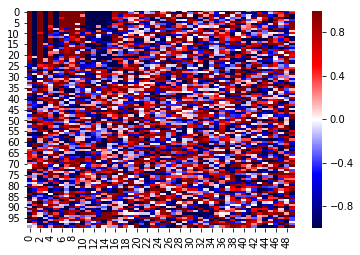

In [10]:
sns.heatmap(sim_X, vmin=-1, vmax=1, cmap='seismic')
pass

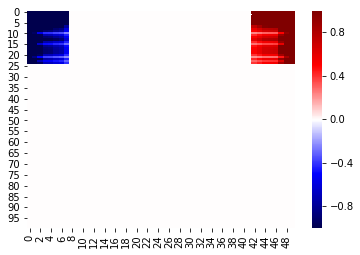

In [11]:
u, s, v= SSVD(sim_X)
sim_X_new = u @ s @ np.sort(np.ravel(v))[::-1].reshape(1,-1)
sns.heatmap(sim_X_new, vmin=-1, vmax=1, cmap='seismic')

This is a plot of the first layer and the checkerboard structure is observed. By applying the SSVD algorithm once, we successfully find the checkerboard structured approximation matrix of $X$.

## 5. Applications to real data sets

### Lung cancer data

This is a dataset from the original paper. The data matrix records the microarray gene expressions. The rows denote subject while the columns denote genes. There are 56 subjects and 12625 genes in this dataset. The subjects have 4 groups: pulmonary carcinoid tumors, colon cancer metastasis, normal lung, small cell carcinoma. We apply SSVD algorithm to this dataset.

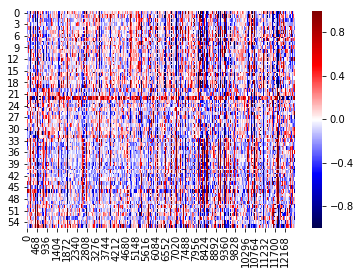

In [12]:
sns.heatmap(cancer, vmin=-1, vmax=1, cmap='seismic')
pass

In [ ]:
u, s, v= SSVD_multi(cancer)

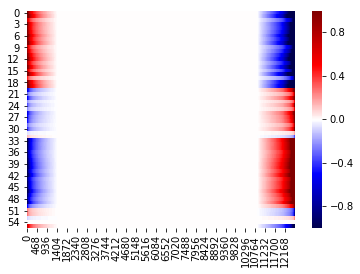

In [27]:
cancer_new = u @ s @ np.sort(np.ravel(v)).reshape(1,-1)
sns.heatmap(cancer_new, vmin=-1, vmax=1, cmap='seismic')

The plot is similar to the plot in the original paper. The genes in the middle white area are not selected. Roughlt the first 1000 genes and the last 1000 genes are siginificant and are related to lung cancer types. There are obvious different features in gene expression for the pulmonary carcinoid tumors group and the normal lung group. The expression of first 1000 genes and last 1000 genes are the opposite for the two groups.

### Golub et al. Gene Expression Data

This dataset comes from a proof-of-concept study published in 1999 by Golub et al. It showed how new cases of cancer could be classified by gene expression monitoring via DNA microarray and thereby provided a general approach for identifying new cancer classes and assigning tumors to known classes. These data were used to classify patients with acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL). There are two classes of cancers.

The original dataset is processed by romoving useless columns and rows. The rows denote samples while the columns denote genes. There are 34 samples and 7129 genes in this dataset. We apply SSVD algorithm to this dataset.

In [14]:
gene = np.array(pd.read_csv('GolubGeneExpression.csv', sep=',', index_col=0, header=0))
group = np.ravel(np.array(pd.read_csv('GolubGroup.csv',index_col=0, header=0)))

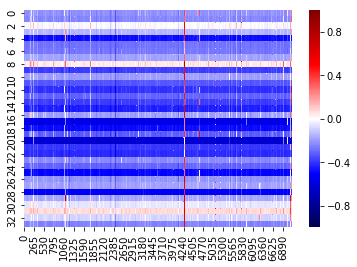

In [15]:
sns.heatmap(gene, cmap='seismic')
pass

In [22]:
u_gene, s_gene, v_gene= SSVD_multi(gene)

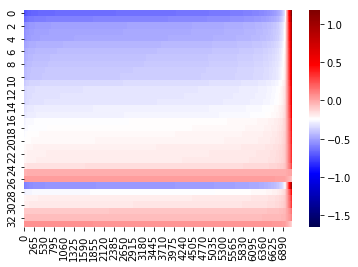

In [23]:
u_gene = np.ravel(u_gene)
groups = np.unique(group)
row_idx = np.empty(0, dtype = 'int')
for g in groups:
    idx, = np.where(group == g)
    row_idx = np.concatenate((row_idx, idx[np.argsort(u_gene[idx])]))
gene_new = u_gene[row_idx].reshape(-1,1) @ s_gene @ np.sort(np.ravel(v_gene))[::-1].reshape(1,-1)
sns.heatmap(gene_new, cmap='seismic')
pass

We can see from this plot that most of the genes are significent. The first 6200 genes have opposite expression for the two large groups and the last 200 genes have basically the same expression for all the subjects.

## 6. Comparative analysis with competing algorithms

In this section, we apply two other algorithms to the simulated dataset and compare them with SSVD based on accuracy. These algorithms are LASSO regression and sparse principal component analysis(SPCA). They are comparable to SSVD because they decompose the data matrix and use a panelty term to detect the underlying sparse structure. LASSO is implemented through the function SSVD written before. The only change is to set the weight parameters as 0 so that each entry in  $u$ and $v$ contributes the same to the panelty term. SPCA is implemented through the native library function sklearn.decomposition.SparsePCA. The default sparsity controlling parameter(panelty parameter) is 1. We also evaluate the case when it is set as 2.

To test these algorithms, we do a rank-1 approximation to get $\hat{u}$ and $\hat{v}$ and compare them to the true  $u$ and $v$ based on zero identification and nonzero identification. This procedure is repeated 100 times and the final results are average values.

In [25]:
def performance(x, x_hat):
    '''
    evaluate the estimated x  in terms of rate of correctly identified 
    zeros, rate of correctly identified nonzeros and misclassification rate
    '''
    
    n_zero = np.sum((x == 0) & (x_hat == 0))
    r_zero = n_zero / np.sum(x == 0)
    n_nonzero = np.sum((x != 0) & (x_hat != 0))
    r_nonzero = n_nonzero / np.sum(x != 0)
    r_miss =(len(x) - n_zero - n_nonzero) / len(x)
    return r_zero, r_nonzero, r_miss

In [189]:

num = 100
u_r_zero = np.zeros((4, num))            # rate of correctly identified zeros for u
u_r_nonzero = np.zeros((4, num))     # rate of correctly identified non_zeros for u
u_r_miss = np.zeros((4, num))        # misclassification rate for u

v_r_zero = np.zeros((4, num))            # rate of correctly identified zeros for v
v_r_nonzero = np.zeros((4, num))     # rate of correctly identified non_zeros for v
v_r_miss = np.zeros((4, num))        # misclassification rate for v

for i in range(num):
    sim_X = X + np.random.randn(m, n)
    
    #SSVD
    u_hat, _, v_hat = SSVD(sim_X)
    u_r_zero[0, i], u_r_nonzero[0, i], u_r_miss[0, i] = performance(u, u_hat)
    v_r_zero[0, i], v_r_nonzero[0, i], v_r_miss[0, i] = performance(v, v_hat)
    
   
    #LASSO
    u_hat, _, v_hat = SSVD(sim_X, gamma_u = 0, gamma_v=0)
    u_r_zero[1, i], u_r_nonzero[1, i], u_r_miss[1, i] = performance(u, u_hat)
    v_r_zero[1, i], v_r_nonzero[1, i], v_r_miss[1, i] = performance(v, v_hat)
    
    #Sparse PCA with default weight parameter 
    SPCA = SparsePCA(n_components=1)
    u_hat = SPCA.fit(sim_X.T).components_[0].reshape((-1,1))
    v_hat = SPCA.fit(sim_X).components_[0].reshape((-1,1))
    u_r_zero[2, i], u_r_nonzero[2, i], u_r_miss[2, i] = performance(u, u_hat)
    v_r_zero[2, i], v_r_nonzero[2, i], v_r_miss[2, i] = performance(v, v_hat)  
    
    #Sparse PCA with weight parameter = 2
    SPCA = SparsePCA(n_components=1, alpha=2)
    u_hat = SPCA.fit(sim_X.T).components_[0].reshape((-1,1))
    v_hat = SPCA.fit(sim_X).components_[0].reshape((-1,1))
    u_r_zero[3, i], u_r_nonzero[3, i], u_r_miss[3, i] = performance(u, u_hat)
    v_r_zero[3, i], v_r_nonzero[3, i], v_r_miss[3, i] = performance(v, v_hat)        
    


In [340]:
stats = np.zeros((8,3))
stats[0:7:2, 0] = np.round(u_r_zero.mean(axis = 1) * 100, 2)
stats[0:7:2, 1] = np.round(u_r_nonzero.mean(axis = 1) * 100, 2)
stats[0:7:2, 2] = np.round(u_r_miss.mean(axis = 1) * 100, 2)

stats[1:8:2, 0] = np.round(v_r_zero.mean(axis = 1) * 100, 2)
stats[1:8:2, 1] = np.round(v_r_nonzero.mean(axis = 1) * 100, 2)
stats[1:8:2, 2] = np.round(v_r_miss.mean(axis = 1) * 100, 2)


In [226]:
results = pd.DataFrame(stats)
results.columns = ['Average Rate of Correctly Identified Zeros(%)',
                   'Average Rate of Correctly Identified Nonzeros(%)', 'Average Misclassification Rate(%)']
results=results.T
results.columns = ['u', 'v', 'u', 'v', 'u', 'v', 'u', 'v']
results.columns=pd.MultiIndex.from_product([
    ['SSVD' ,'LASSO', 'SPCA(1)', 'SPCA(2)'], ['u', 'v']
], names=['Algorithm', 'Singular Vector'])
results.T

Average Rate of Correctly Identified Zeros(%)  \
Algorithm Singular Vector                                                  
SSVD      u                                                        98.99   
          v                                                        99.26   
LASSO     u                                                        92.76   
          v                                                        92.38   
SPCA(1)   u                                                        68.83   
          v                                                        68.68   
SPCA(2)   u                                                        95.52   
          v                                                        95.74   

                           Average Rate of Correctly Identified Nonzeros(%)  \
Algorithm Singular Vector                                                     
SSVD      u                                                           98.92   
          v                                                          100.00   
LASSO     u                                                           99.64   
          v                                                          100.00   
SPCA(1)   u                                                          100.00   
          v                                                          100.00   
SPCA(2)   u                                                           99.64   
          v                                                          100.00   

                           Average Misclassification Rate(%)  
Algorithm Singular Vector                                     
SSVD      u                                             1.03  
          v                                             0.50  
LASSO     u                                             5.52  
          v                                             5.18  
SPCA(1)   u                                            23.38  
          v                                            21.30  
SPCA(2)   u                                             3.45  
          v                                             2.90

The table above reports the comparative analysis results in terms of the average rate of correctly identified zeros, the average rate of correctly identified nonzeros and the average misclassification rate. Among all the algorithms, SSVD does the best in detecting the sparse structure with the lowest misclassification rate $1.11\%$ and $0.3\%$. LASSO has a slightly higher misclassification rate, implying that each entry of $u$ and $v$ should have different contribution to the panelty term. SPCA with panelty parameter = 2 is slightly worse than SSVD but better than LASSO. SPCA with panelty parameter = 1 has a bad performance therefore it is not suitable to the simulated dataset generated above. The best choice of panelty parameter is related to the structure of the dataset. Here, we do not bother to select the best panelty parameter.

## 7. Conclusion/discussion


Starting from SVD algorithm, SSVD is introduced by imposing sparsity on two singular vectors, which helps select groups of most related variables for different observations. According to the applications to the simulated dataset and the two real world datasets, SSVD algorithm performs well in finding the sparse checkerboard structured matrix approximation. SSVD is more suitable for high-dimentional low sample size dataset. Optimized SSVD by parallelism runs faster so big dataset can also be analyzed in short time.

SSVD algorithm is used in computational biology to help biological interpretation such as microarray gene expression analysis. It is possible to find the relationship of centain genes and certain diseases. SSVD is also used in text categorization, nutritional data and other HDLSS datasets to find the association of rows and columns, thus a useful tool for biclustering.

The limitation is the weight parameters $\gamma$ we used in SSVD. This is set to 2 in the algorithm,  but we do not know if 2 is a best choice. The choice of the weight parameters $\gamma$ may depend on the algorithm itself and may also depend on the properties of the dataset analyzed. So the peoblem about how to choose $\gamma$ needed further exploration and analysis.

## References

Lee, M., Shen, H., Huang, J., and Marron, J. (2010). Biclustering via sparse singular value decomposition. Biometrics 66, 1087-1095.

Zou, H., Hastie, T., and Tibshirani, R. (2006). Sparse principal component analysis. Journal of Computational and Graphical Statistics 15, 265–286.

Min, W., Liu, J., and Zhang S. (2018). Group-sparse SVD Models and Their Applications in Biological Data. 